In [25]:
# Basic packages
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [26]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

In [27]:
df = pd.read_csv('/content/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
11745,@USAirways had a horrible experience flying fr...,negative
819,@united Delay DEN-CLE because they have to ma...,negative
9555,@USAirways @AmericanAir at 9:05am after the pl...,negative
10395,@USAirways First class service on US 769 PHL-M...,positive
4747,@SouthwestAir flight 1028 no delayed 1.5 hours...,negative


In [28]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split()
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
        return " ".join(clean_words)

def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)

df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()

,text,airline_sentiment
11745,horrible experience flying Montego Bay Philad...,negative
819,Delay DEN-CLE manually enter baggage tags? Re...,negative
9555,"9:05am plane left: ""why no agents doors clos...",negative
10395,First class service US 769 PHL-MCO today flig...,positive
4747,flight 1028 no delayed 1.5 hours. Another wee...,negative


In [30]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13176
# Test data samples: 1464


In [31]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 13176 documents
10000 words in dictionary
Top 5 most common words are: [('flight', 3528), ('not', 1446), ('no', 1349), ('get', 1219), ('t', 1075)]


In [32]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

" What  said." is converted into [11, 287, 275, 11, 287, 75, 130, 224, 47, 24, 6026]


In [33]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[11, 287, 275, 11, 287, 75, 130, 224, 47, 24, 6026]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 9.0 features with a value of 1.


In [34]:
from keras.utils import to_categorical


In [35]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"neutral" is converted into 2
"2" is converted into [0. 0. 1.]


In [36]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1318, 10000)


In [37]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                640064    
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644419 (2.46 MB)
Trainable params: 644419 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])

    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)

    return history

In [39]:
base_history = deep_model(base_model)

In [40]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

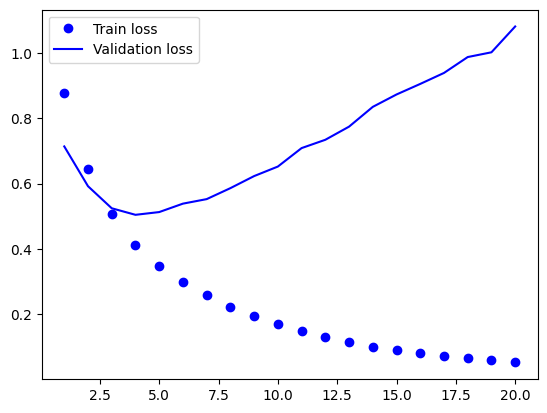

In [41]:
eval_metric(base_history, 'loss')


In [47]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                320032    
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 320131 (1.22 MB)
Trainable params: 320131 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
reduced_history = deep_model(reduced_model)


In [49]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

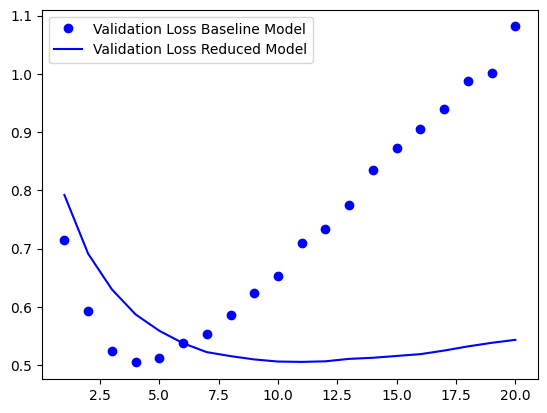

In [50]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')


In [51]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                640064    
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644419 (2.46 MB)
Trainable params: 644419 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
reg_history = deep_model(reg_model)


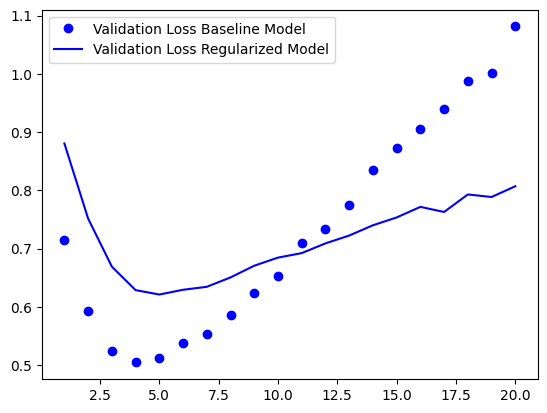

In [53]:

compare_loss_with_baseline(reg_history, 'Regularized Model')


In [54]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644419 (2.46 MB)
Trainable params: 644419 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
drop_history = deep_model(drop_model)


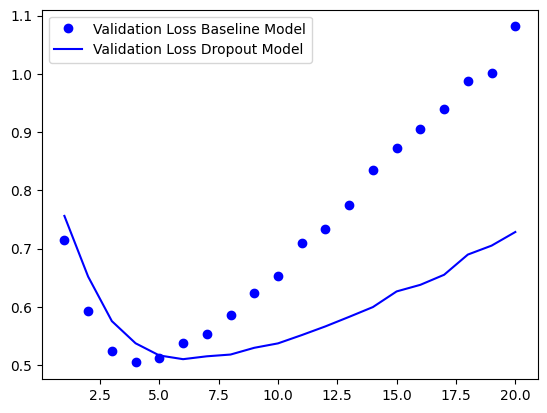

In [56]:
compare_loss_with_baseline(drop_history, 'Dropout Model')


In [57]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)

    return results

In [58]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

46/46 [==============================] - 0s 4ms/step - loss: 0.9299 - accuracy: 0.7732
/n
Test accuracy of baseline model: 77.32%


In [59]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

46/46 [==============================] - 0s 4ms/step - loss: 0.5740 - accuracy: 0.7876
/n
Test accuracy of reduced model: 78.76%


In [60]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

46/46 [==============================] - 0s 6ms/step - loss: 0.7330 - accuracy: 0.7869
/n
Test accuracy of regularized model: 78.69%


In [61]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

46/46 [==============================] - 0s 4ms/step - loss: 0.7233 - accuracy: 0.7999
/n
Test accuracy of dropout model: 79.99%
